# Retail Stock Optimization


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
RSO_df=pd.read_csv('Data/Smart Inventory Optimization for Retail Chains.csv')


In [4]:
RSO_df

,date,store_id,sku_id,units_sold,price,promotion_flag,holiday_flag,weather_score,lead_time_days
0,2023-01-01,1,1,22,37.94,0,1,0.16,3
1,2023-01-01,1,2,19,9.50,0,1,0.33,3
2,2023-01-01,1,3,17,13.18,0,1,0.30,6
3,2023-01-01,1,4,22,5.32,0,1,0.52,7
4,2023-01-01,1,5,17,21.49,0,1,0.79,3
...,...,...,...,...,...,...,...,...,...
180995,2023-06-30,10,96,21,6.90,1,0,0.77,2
180996,2023-06-30,10,97,24,40.57,0,0,0.40,6
180997,2023-06-30,10,98,26,10.03,1,0,0.54,1
180998,2023-06-30,10,99,19,13.61,0,0,0.70,1


## EDA

In [5]:

print("Summary Statistics:")
print(RSO_df.describe())


Summary Statistics:
            store_id        sku_id     units_sold          price  \
count  181000.000000  181000.00000  181000.000000  181000.000000   
mean        5.500000      50.50000      19.472525      27.533462   
std         2.872289      28.86615       5.010427      13.013038   
min         1.000000       1.00000       0.000000       5.000000   
25%         3.000000      25.75000      16.000000      16.220000   
50%         5.500000      50.50000      19.000000      27.540000   
75%         8.000000      75.25000      23.000000      38.810000   
max        10.000000     100.00000      42.000000      50.000000   

       promotion_flag   holiday_flag  weather_score  lead_time_days  
count   181000.000000  181000.000000  181000.000000   181000.000000  
mean         0.199762       0.005525       0.499610        3.995680  
std          0.399823       0.074124       0.288539        1.999921  
min          0.000000       0.000000       0.000000        1.000000  
25%          0.00

In [6]:
# Check for missing values
print("\nMissing Values:")
print(RSO_df.isnull().sum())



Missing Values:
date              0
store_id          0
sku_id            0
units_sold        0
price             0
promotion_flag    0
holiday_flag      0
weather_score     0
lead_time_days    0
dtype: int64


In [7]:

# Feature engineering
RSO_df['date'] = pd.to_datetime(RSO_df['date'])
RSO_df['day_of_week'] = RSO_df['date'].dt.dayofweek
RSO_df['week_of_year'] = RSO_df['date'].dt.isocalendar().week


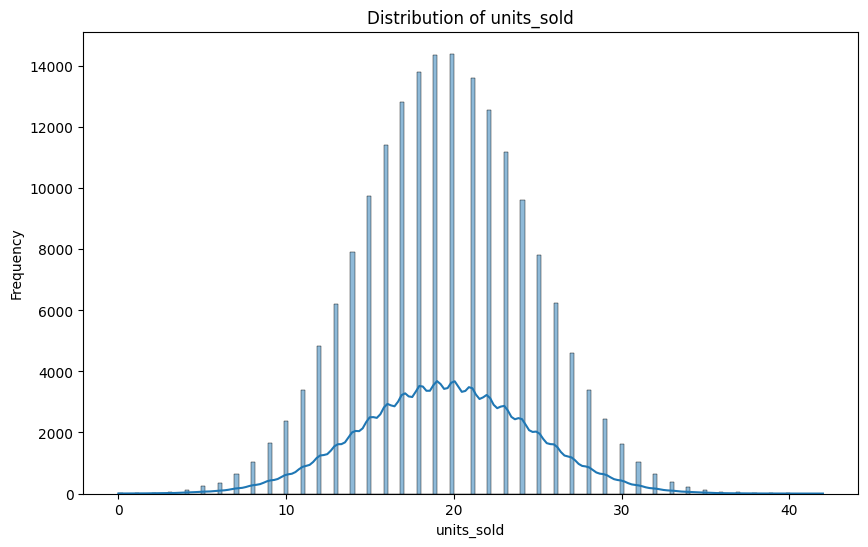

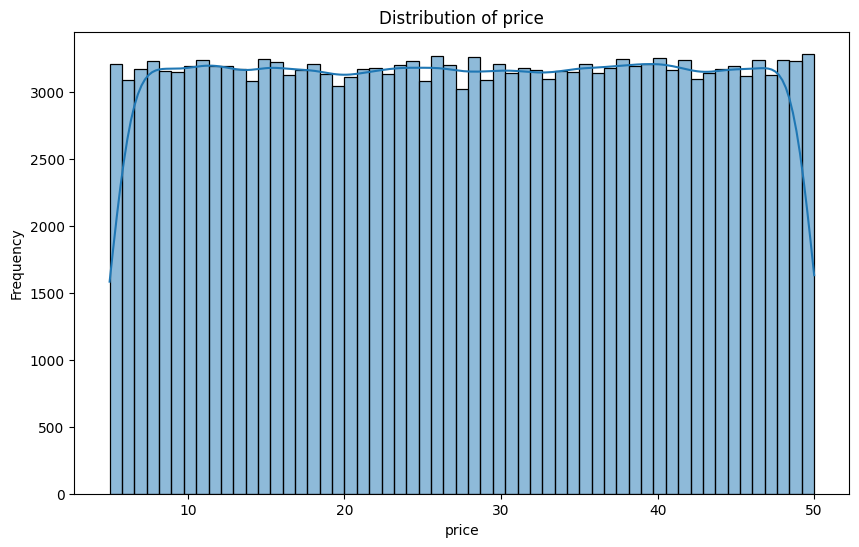

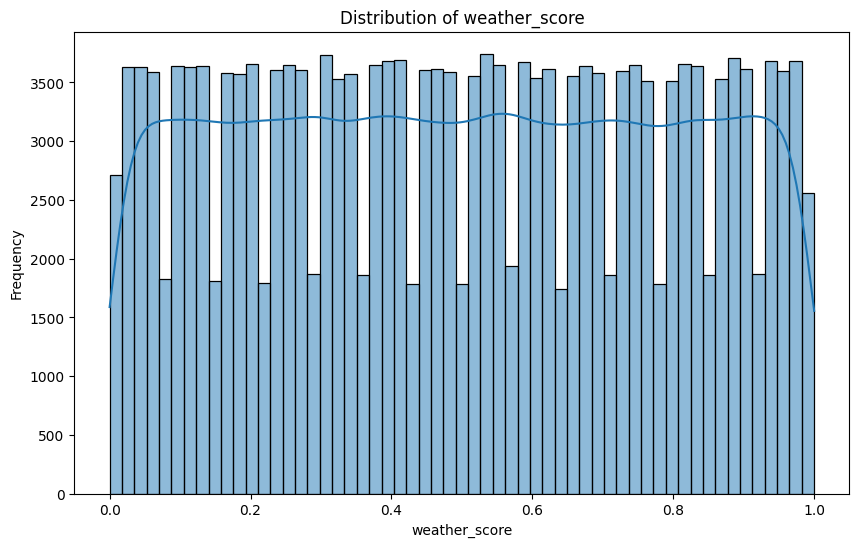

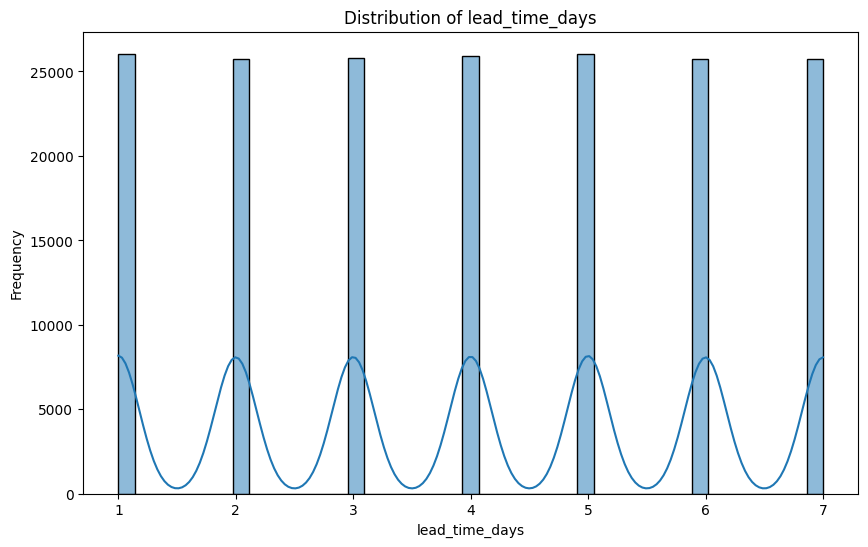

In [8]:

numerical_features = ['units_sold', 'price', 'weather_score', 'lead_time_days']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(RSO_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


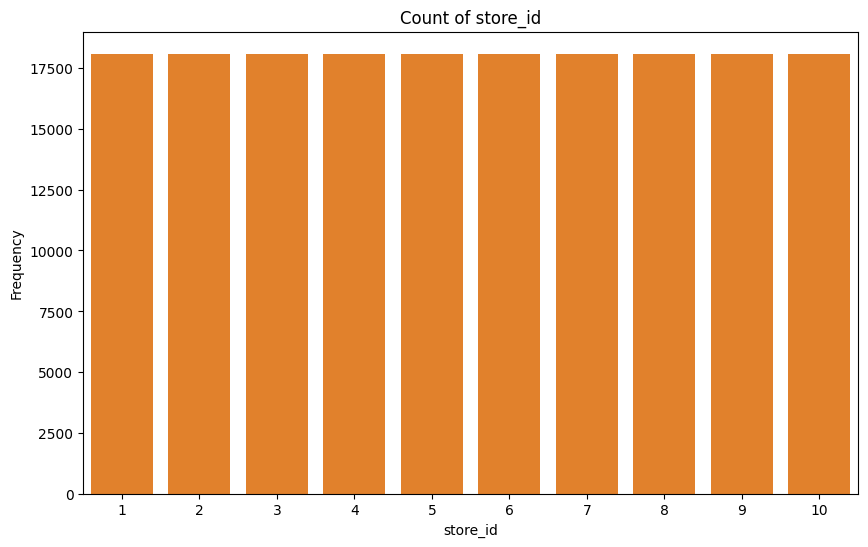

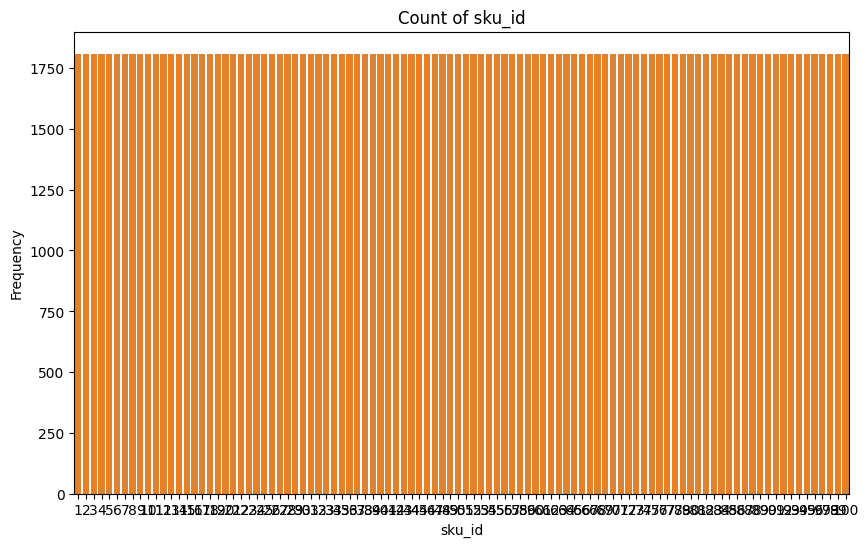

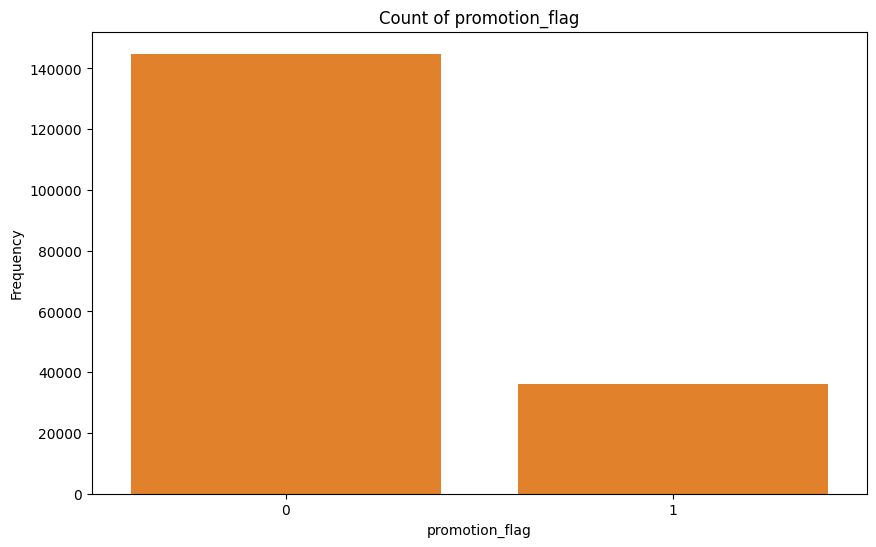

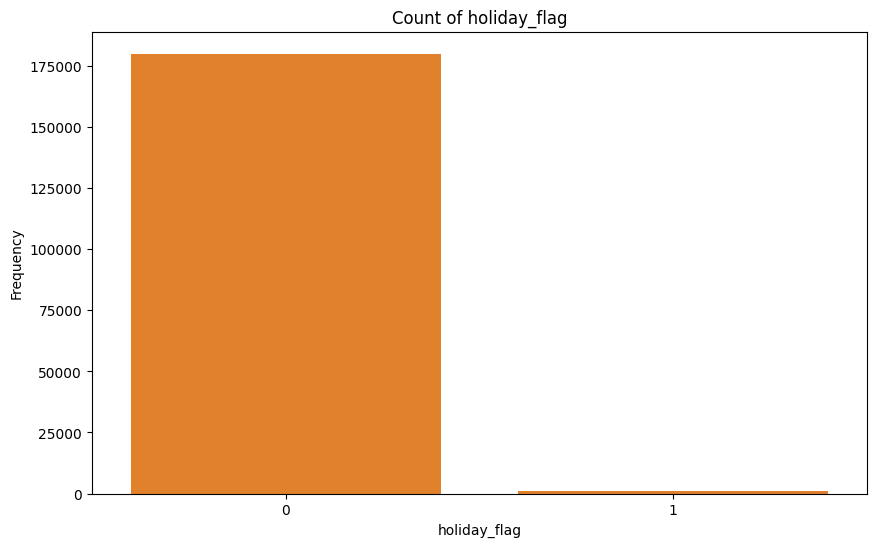

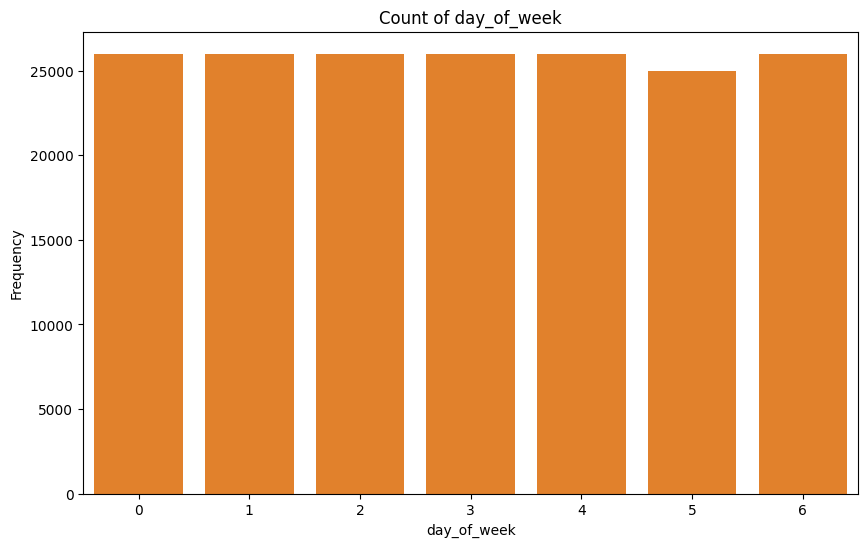

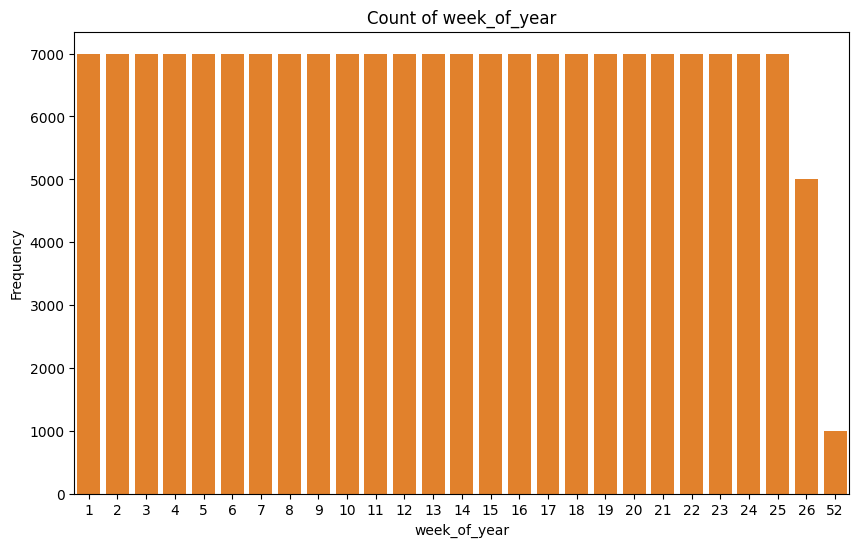

In [9]:

# Bar plots for categorical features
categorical_features = ['store_id', 'sku_id', 'promotion_flag', 'holiday_flag', 'day_of_week', 'week_of_year']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=RSO_df[feature])
    sns.countplot(x=RSO_df[feature])
    plt.title(f'Count of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()



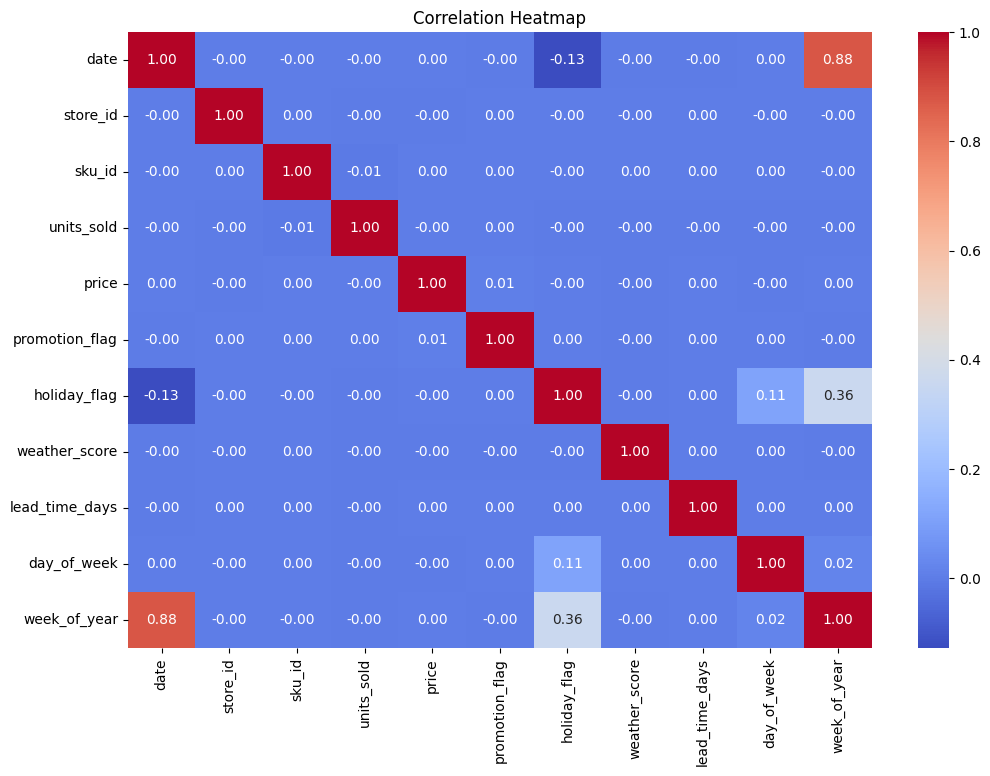

In [10]:

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(RSO_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


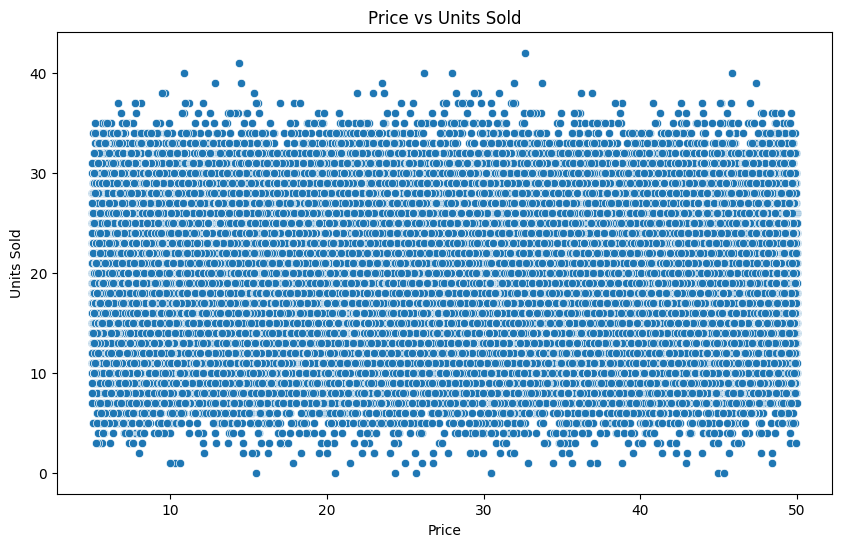

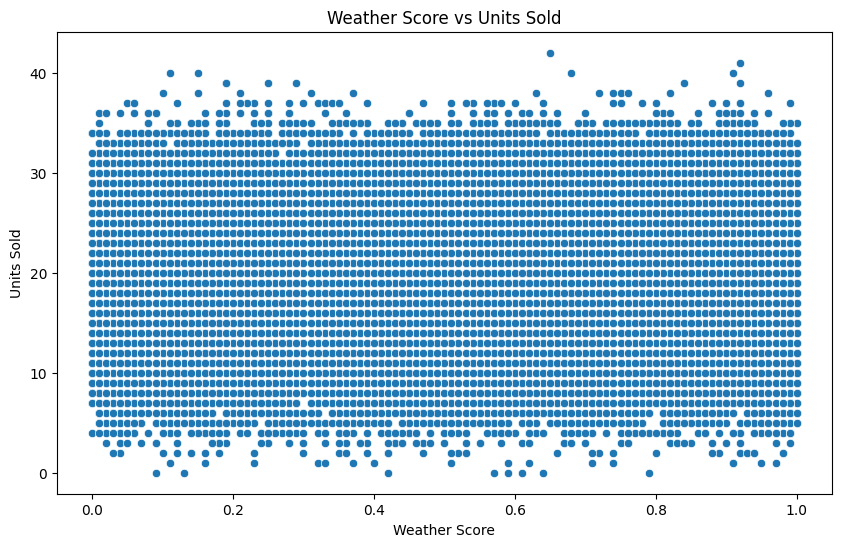

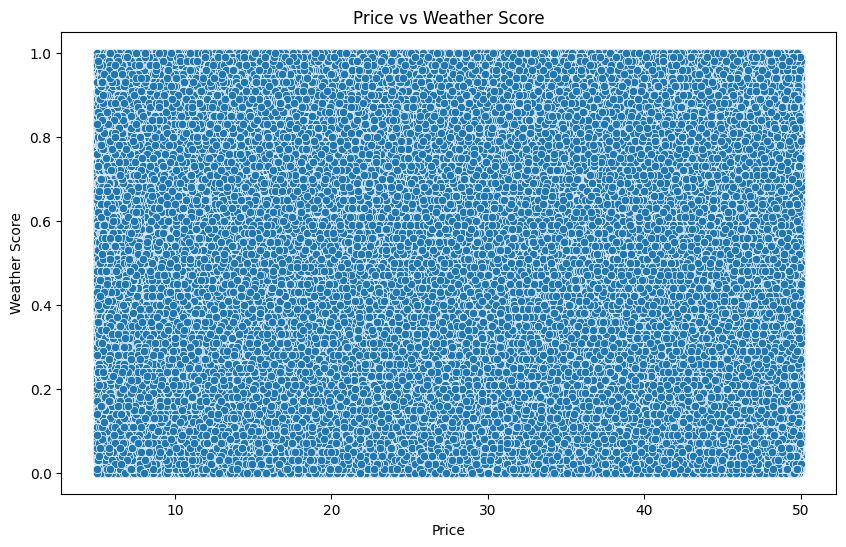

In [11]:


# Scatter plots showing relationships between price, weather_score, and units_sold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='units_sold', data=RSO_df)
plt.title('Price vs Units Sold')
plt.xlabel('Price')
plt.ylabel('Units Sold')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='weather_score', y='units_sold', data=RSO_df)
plt.title('Weather Score vs Units Sold')
plt.xlabel('Weather Score')
plt.ylabel('Units Sold')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='weather_score', data=RSO_df)
plt.title('Price vs Weather Score')
plt.xlabel('Price')
plt.ylabel('Weather Score')
plt.show()


## Prerpocessing

In [12]:

# Prepare features and target
X = RSO_df.drop(columns=['date', 'units_sold'])
y = RSO_df['units_sold']

# One-hot encode categorical variables
categorical_features = ['store_id', 'sku_id', 'promotion_flag', 'holiday_flag']
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(X[categorical_features])
X_encoded_RSO_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with the rest of the dataset
X = X.drop(columns=categorical_features)
X = pd.concat([X.reset_index(drop=True), X_encoded_RSO_df.reset_index(drop=True)], axis=1)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Train the XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.01, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [24]:
y_pred

array([19.486115, 19.488417, 19.500252, ..., 19.440554, 19.486115,
       19.499949], shape=(36200,), dtype=float32)

In [25]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 4.998724965602556
R² Score: -0.00041925907135009766


## Prescriptive modeling

In [ ]:
from docplex.mp.model import Model

# Sample predicted demand for MILP
predicted_demand = {
    ('Store_1', 'SKU_1'): int(y_pred[0]),
    ('Store_1', 'SKU_2'): int(y_pred[1]),
    ('Store_1', 'SKU_3'): int(y_pred[2]),
    ('Store_2', 'SKU_1'): int(y_pred[3]),
    ('Store_2', 'SKU_2'): int(y_pred[4]),
    ('Store_2', 'SKU_3'): int(y_pred[5]),
}

# Cost parameters
holding_cost = {'SKU_1': 0.5, 'SKU_2': 0.6, 'SKU_3': 0.7}
ordering_cost = {'SKU_1': 1.0, 'SKU_2': 1.2, 'SKU_3': 1.5}
storage_capacity = {'Store_1': 500, 'Store_2': 450}

# MILP model
milp_model = Model(name='Inventory Optimization')
order_qty = milp_model.integer_var_dict(predicted_demand.keys(), name='order_qty')

# Objective: minimize total cost
milp_model.minimize(
    milp_model.sum(
        (holding_cost[sku] + ordering_cost[sku]) * order_qty[store, sku]
        for store, sku in predicted_demand
    )
)

# Constraints
for (store, sku), demand in predicted_demand.items():
    milp_model.add_constraint(order_qty[store, sku] >= demand, f"demand_{store}_{sku}")

for store in ['Store_1', 'Store_2']:
    milp_model.add_constraint(
        milp_model.sum(order_qty[store, sku] for sku in ['SKU_1', 'SKU_2', 'SKU_3']) <= storage_capacity[store],
        f"capacity_{store}"
    )

# Solve
solution = milp_model.solve()

# Output
if solution:
    print("Optimal Order Quantities:")
    for (store, sku) in predicted_demand:
        print(f"{store}, {sku}: {order_qty[store, sku].solution_value}")
    print(f"Total Cost: {solution.objective_value}")
else:
    print("No solution found.")


ModuleNotFoundError: No module named 'docplex'